# Problem Statement

**One of the largest retail chains in the world wants to use their vast data source to build an efficient forecasting model to predict the sales for each SKU in its portfolio at its 76 different stores using historical sales data for the past 3 years on a week-on-week basis. Sales and promotional information is also available for each week - product and store wise.** 

**However, no other information regarding stores and products are available. Can you still forecast accurately the sales values for every such product/SKU-store combination for the next 12 weeks accurately? If yes, then dive right in!**

# Data Analysis and Feature Engineering

In [1]:
pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of th

In [3]:
train = pd.read_csv('/content/drive/My Drive/Demand Forecasting/train.csv')
test = pd.read_csv('/content/drive/My Drive/Demand Forecasting/test.csv')

In [4]:
train['week'] = pd.to_datetime(train['week'])
test['week'] = pd.to_datetime(test['week'])

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   record_ID        150150 non-null  int64         
 1   week             150150 non-null  datetime64[ns]
 2   store_id         150150 non-null  int64         
 3   sku_id           150150 non-null  int64         
 4   total_price      150150 non-null  float64       
 5   base_price       150150 non-null  float64       
 6   is_featured_sku  150150 non-null  int64         
 7   is_display_sku   150150 non-null  int64         
 8   units_sold       150150 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 10.3 MB


In [6]:
train.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [7]:
train.describe()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,9199.422511,254761.132468,206.628502,219.425927,0.095611,0.133200,51.674206
std,61386.037861,615.591445,85547.306447,103.310400,110.961712,0.294058,0.339792,60.207904
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000


In [8]:
train

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52
...,...,...,...,...,...,...,...,...,...
150145,212638,2013-09-07,9984,223245,235.8375,235.8375,0,0,38
150146,212639,2013-09-07,9984,223153,235.8375,235.8375,0,0,30
150147,212642,2013-09-07,9984,245338,357.6750,483.7875,1,1,31
150148,212643,2013-09-07,9984,547934,141.7875,191.6625,0,1,12


In [9]:
train.drop(train[train['units_sold']>1500].index,inplace=True)

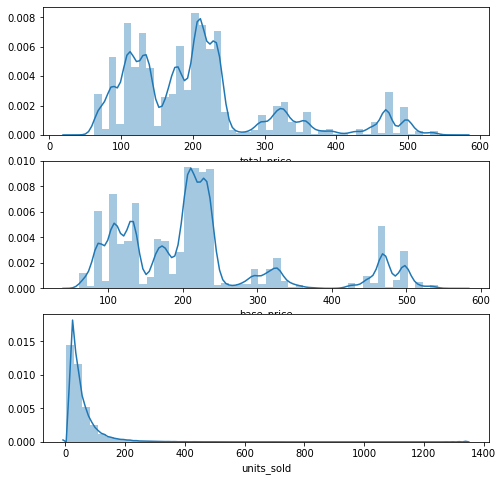

In [14]:
#Distributions of numerical variables
num_cols = ['total_price','base_price','units_sold']
fig,ax = plt.subplots(3,1,figsize=(8,8),squeeze=False)
r=0
c=0
for i in num_cols:
  sns.distplot(train[i],ax=ax[r][c])
  r+=1



**Its always a good strategy to reduce the variance and skewness from the variable distributions(including target variable)**



In [15]:
train['units_sold']=np.log1p(train['units_sold'])


In [16]:
train['total_price']=np.log(train['total_price'])
test['total_price']=np.log(test['total_price'])

In [17]:
train['base_price']=np.log(train['base_price'])
test['base_price']=np.log(test['base_price'])

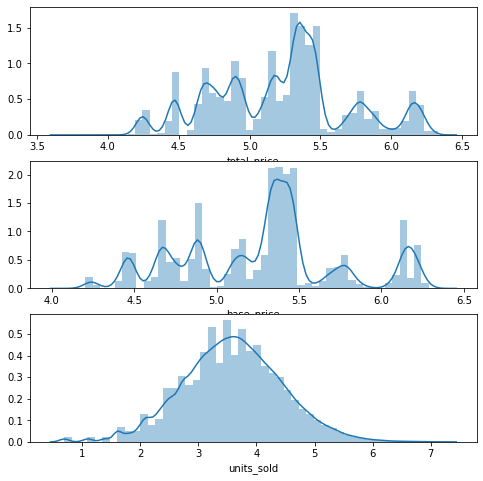

In [18]:
#Distributions of numerical variables after transformation

fig,ax = plt.subplots(3,1,figsize=(8,8),squeeze=False)
r=0
c=0
for i in num_cols:
  sns.distplot(train[i],ax=ax[r][c])
  r+=1


**Making some extra features**

In [ ]:
train['IsDiscounted'] = np.where(train['total_price']<train['base_price'],1,0)
test['IsDiscounted'] = np.where(test['total_price']<test['base_price'],1,0)

In [19]:
train['Discount'] = train['base_price'] - train['total_price']
test['Discount'] = test['base_price'] - test['total_price']

train['Discount']=np.where(train['Discount'] > 0 ,np.log1p(train['Discount']),0)
test['Discount']=np.where(test['Discount'] > 0 ,np.log1p(test['Discount']),0)


In [20]:
train['Premium'] =  train['total_price'] - train['base_price']
test['Premium'] =  test['total_price'] - test['base_price']
train['Premium']=np.where(train['Premium'] > 0 ,np.log1p(train['Premium']),0)
test['Premium']=np.where(test['Premium'] > 0 ,np.log1p(test['Premium']),0)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
#Extracting only Month component from datetime as other components did not have much afffect on target variable
from pandas import datetime
train['Month'] = [date.month for date in train.week]
test['Month'] = [date.month for date in test.week]


In [22]:
#function for converting datetime object to seconds format so that it can be processed by the model
from datetime import datetime
import time
def datetounix(df):
    # Initialising unixtime list
    unixtime = []
    
    # Running a loop for converting Date to seconds
    for date in df['week']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['week'] = unixtime
    return(df)

In [23]:
train = datetounix(train)
test = datetounix(test)

In [24]:
X = train.drop(['units_sold'],axis=1)
y = train['units_sold']

In [25]:
test_final = test

In [29]:
train.head().append(train.tail())

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,Discount,Premium,Month
0,1,1.295222e+09,8091,216418,4.595499,4.717270,0,0,3.044522,0.114909,0.0,1
1,2,1.295222e+09,8091,216419,4.595499,4.595499,0,0,3.367296,0.000000,0.0,1
2,3,1.295222e+09,8091,216425,4.897467,4.897467,0,0,2.995732,0.000000,0.0,1
3,4,1.295222e+09,8091,216233,4.897467,4.897467,0,0,3.806662,0.000000,0.0,1
4,5,1.295222e+09,8091,217390,4.949292,4.949292,0,0,3.970292,0.000000,0.0,1
150145,212638,1.378512e+09,9984,223245,5.463143,5.463143,0,0,3.663562,0.000000,0.0,9
150146,212639,1.378512e+09,9984,223153,5.463143,5.463143,0,0,3.433987,0.000000,0.0,9
150147,212642,1.378512e+09,9984,245338,5.879625,6.181646,1,1,3.465736,0.263918,0.0,9
150148,212643,1.378512e+09,9984,547934,4.954329,5.255736,0,1,2.564949,0.263446,0.0,9
150149,212644,1.378512e+09,9984,679023,5.457082,5.457082,0,0,2.772589,0.000000,0.0,9


In [30]:
test.head().append(test.tail())

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,Discount,Premium,Month
0,212645,1.373933e+09,8091,216418,4.684905,4.684905,0,0,0.000000,0.0,7
1,212646,1.373933e+09,8091,216419,4.691463,4.691463,0,0,0.000000,0.0,7
2,212647,1.373933e+09,8091,216425,4.897467,4.897467,0,0,0.000000,0.0,7
3,212648,1.373933e+09,8091,216233,4.897467,4.897467,0,0,0.000000,0.0,7
4,212649,1.373933e+09,8091,217390,5.174453,5.174453,0,0,0.000000,0.0,7
13855,232281,1.357776e+09,9984,223245,5.487025,5.487025,0,0,0.000000,0.0,1
13856,232282,1.357776e+09,9984,223153,5.484071,5.484071,0,0,0.000000,0.0,1
13857,232285,1.357776e+09,9984,245338,5.947023,5.996079,1,1,0.047891,0.0,1
13858,232286,1.357776e+09,9984,547934,5.255736,5.255736,0,0,0.000000,0.0,1
13859,232287,1.357776e+09,9984,679023,5.457082,5.457082,0,0,0.000000,0.0,1


In [27]:
#function for creating k-fold like validation sets for TS data. Since there is autocorrelation among datapoints we cannot use classical K-Fold approach
def train_test_split(k):
   train_size = int(len(train) * k)
   x_tr, y_tr = X[0:train_size], y[0:train_size]
   x_v,y_v = X[train_size:len(X)], y[train_size:len(X)]
   return x_tr,y_tr,x_v,y_v




In [28]:
#ratios in which train data will be split
ratio = [0.88,0.9,0.92,0.94,0.96]

# Model Building 

## Light-GBM

In [32]:
from lightgbm import LGBMRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error

In [33]:
#Applying K-Fold validation(K=5)
rmsle = 0
for i in ratio:
  x_train,y_train,x_val,y_val = train_test_split(i)
  lgbc=LGBMRegressor(boosting_type='gbdt',n_estimators=800, learning_rate=0.12,objective= 'regression',n_jobs=-1,random_state=100)
  model=lgbc.fit(x_train,y_train)
  pred_val = model.predict(x_val)
   
  print(np.sqrt(mean_squared_log_error(np.exp(y_val), np.exp(pred_val))))
  rmsle+=np.sqrt(mean_squared_log_error(np.exp(y_val),np.exp(pred_val)))
    



print(rmsle/5)

0.44012595511191455
0.411338425821718
0.43028169854184634
0.3851840541718179
0.3936081024298525
0.4121076472154298


In [ ]:
lgbc.fit(X,y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.12, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=800, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=100, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
import eli5
perm = PermutationImportance(lgbc,random_state=100).fit(x_val, y_val)
eli5.show_weights(perm,feature_names=x_val.columns.tolist())

In [ ]:
pred = lgbc.predict(test_final)
pred = np.exp(pred)
# pred = np.abs(pred)

In [ ]:
pred

array([21.07427622, 21.76428239, 27.27239172, ..., 42.72994694,
       12.47475805, 11.3225535 ])

## CatBoost

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostRegressor   
cb = CatBoostRegressor(
    n_estimators = 1000,
    learning_rate = 0.11,
    #iterations=1000,
    loss_function = 'RMSE',
    eval_metric = 'RMSE',
    verbose=0)


In [ ]:
rmsle = 0
for i in ratio:
  x_train,y_train,x_val,y_val = train_test_split(i)

  model=cb.fit(x_train,y_train)
  pred_val = model.predict(x_val)
   
  print(np.sqrt(mean_squared_log_error(np.exp(y_val), np.exp(pred_val))))
  rmsle+=np.sqrt(mean_squared_log_error(np.exp(y_val),np.exp(pred_val)))



print("Test set RMSE:",100*rmsle/5)

0.4349303698245565
0.41615211113728384
0.41909800937586494
0.391888815231071
0.39743338474317114
Test set RMSE: 41.19005380623894


In [ ]:
cb.fit(X,y)

In [ ]:
import eli5
perm = PermutationImportance(cb,random_state=100).fit(x_val, y_val)
eli5.show_weights(perm,feature_names=x_val.columns.tolist())

In [ ]:
pred_cb = cb.predict(test_final)
pred_cb = np.exp(pred_cb)

In [ ]:
pred_cb

array([35.72683421, 27.52850516, 19.71160232, ..., 35.51167656,
       11.63234822, 11.3979454 ])

In [ ]:
#Averaging out predictions from both the models.
pred_final =0.75*pred + 0.25*pred_cb
pred_final

array([24.73741572, 23.20533808, 25.38219437, ..., 40.92537934,
       12.26415559, 11.34140147])

In [ ]:
df_solution = pd.DataFrame()
df_solution['record_ID'] = test.record_ID
df_solution['units_sold'] = pred_final
df_solution

,record_ID,units_sold
0,212645,24.737416
1,212646,23.205338
2,212647,25.382194
3,212648,27.191410
4,212649,24.100005
...,...,...
13855,232281,51.457583
13856,232282,36.385884
13857,232285,40.925379
13858,232286,12.264156
